In [1]:
from desc import set_device
set_device("gpu")

/home/fcastro/DESC/desc/__init__.py:98: UserWarning: No GPU found, falling back to CPU
  warnings.warn(colored("No GPU found, falling back to CPU", "yellow"))


In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnpå
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif

from desc.utils import cross, dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import FourierCurrentPotentialField
#from desc.magnetic_fields._current_potential import run_regcoil

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

from desc.fns_simp import (plot_figure,
                           plot_figure2,
                           plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

from find_dips import (shift_grid, omega_pair, iso_coords_interp)

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64
Using device: CPU, with 318.03 GB available memory


In [3]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

eq = eq_QA    
###
surf_winding = load("iso_coords/surf.h5")

In [4]:
# Evaluate Green's function for flat tori
sgrid = LinearGrid(M = 100, N = 150, NFP = 1)# surf_winding.NFP)
sdata = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid)
name = 'iso_coords/'
sdata = iso_coords_interp(name, sdata, sgrid, surf_winding)

G = np.load("iso_coords/G.npy")
K_sec = G * cross(sdata["n_rho"], sdata["e^u_s"])
#G * cross(kdata["n_rho"], kdata["H_1"])
K_sv = surf_winding.compute(["K"],grid = sgrid)["K"]

/home/fcastro/DESC/desc/transform.py:70: UserWarning: Unequal number of field periods for grid 1 and basis 3.
  warnings.warn(


<class 'numpy.ndarray'>


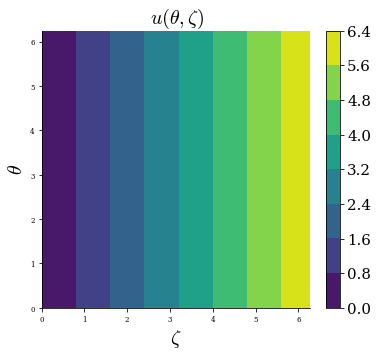

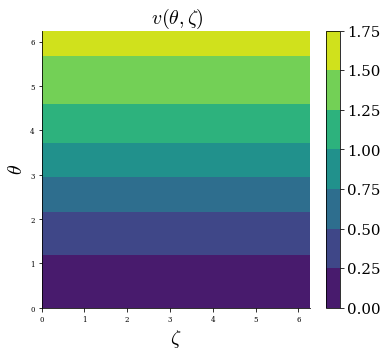

In [5]:
# Confirm that variables have the same shape
plot_figure2(sdata["u_iso"],sgrid,''r' $ u(\theta,\zeta)$ ')
plot_figure2(sdata["v_iso"],sgrid,''r' $ v(\theta,\zeta)$ ')
#plot_figure2(sdata["lambda_iso"],sgrid,''r' $ \lambda $ ')

In [6]:
eps = 1e-2
dt = eps
dz = eps
d0 = eps/3

In [7]:
grid_M = 50
grid_N = 50

In [8]:
egrid = LinearGrid(M = grid_M, N = grid_N,NFP = eq.NFP)
edata = eq.compute(["n_rho","B"], grid = egrid)

#B_s = edata["B"]
B_sec = np.load('iso_coords/B_sec_'+str(grid_M)+'x'+str(grid_N)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
B_s = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid, basis = "rpz" )
#B_s = _compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
rhs = jnp.concatenate((B_s[:,0],B_s[:,1],B_s[:,2]))
#- dot( edata["n_rho"],  B_sec )

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


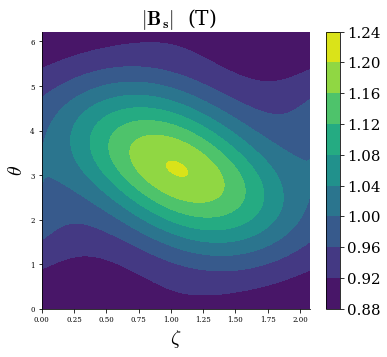

In [9]:
plot_figure2( dot(B_sec,B_sec)**(1/2), egrid,''r' $ | \mathbf{B_{s} } |$  (T)')

In [10]:
bn = dot(edata["n_rho"],B_s + B_sec) * dot(B_s + B_sec, B_s + B_sec) ** (-1/2)

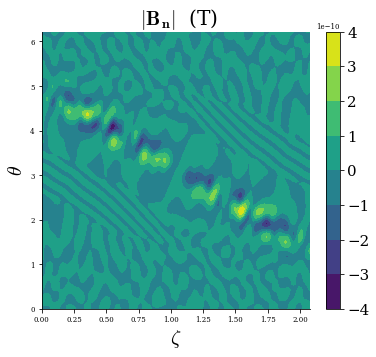

In [11]:
plot_figure2( bn, egrid,''r' $ | \mathbf{B_{n} } |$  (T)')

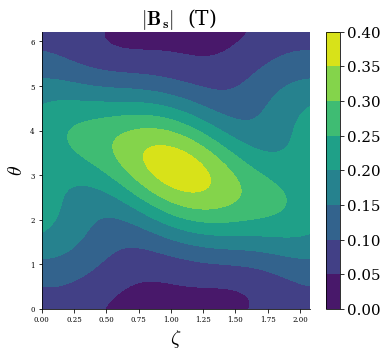

In [12]:
plot_figure2( dot(B_s,B_s) ** (1/2), egrid,''r' $ | \mathbf{B_{s}} |$  (T)')

In [13]:
N = 20 # Terms toa pproximate the infinite series

# Numer of dipoles
#sMv = np.asarray([5,10,15,20,])
#sMv = np.asarray([10,10,10,10,10,10])
#sNv = np.asarray([5,10,15,20,25,30])
sMv = np.asarray([5])
sNv = sMv

b_chi = []
Bn_chi = []
max_I = []

In [14]:
grid_M2 = grid_M #40
grid_N2 = grid_N #40

egrid2 = LinearGrid(M = grid_M2, N = grid_N2, NFP = eq.NFP)
edata2 = eq.compute(["n_rho"], grid = egrid2)

B_sec2 = np.load('iso_coords/B_sec_'+str(grid_M2)+'x'+str(grid_N2)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid2, basis = "rpz" )
B_s2 = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid2, basis = "rpz" )
#B_s2 = edata2["B"]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [15]:
bn = dot(edata2["n_rho"],B_s2 + B_sec2) * dot(B_s2 + B_sec2,B_s2 + B_sec2) ** (-1/2)

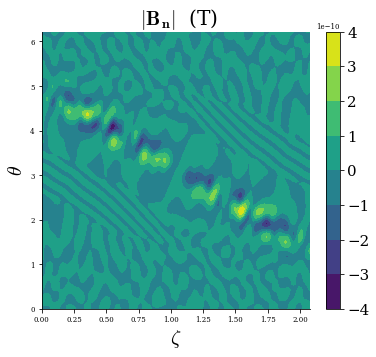

In [16]:
plot_figure2( bn, egrid2,''r' $ | \mathbf{B_{n} } |$  (T)')

In [17]:
p_M = sMv[0]
p_N = sNv[0]
    
x = jnp.ones( ( p_M * 2 + 1 ) * ( p_N * 2 + 1 ) * 2 + 0 )
theta = jnp.linspace(2 * jnp.pi * (1 / (p_M * 2 + 1)) * 1/2,
                         2 * jnp.pi * (1 - 1 / (p_M * 2 + 1) * 1/2),
                         p_M * 2 + 1)

zeta = jnp.linspace(2 * jnp.pi / sgrid.NFP * (1 / (p_N * 2 + 1)) * 1/2,
                        2 * jnp.pi / sgrid.NFP * (1 - 1 / (p_N * 2 + 1) * 1/2),
                        p_N * 2 + 1)

(dl_data, dr_data, dd_data, du_data) = shift_grid(theta, zeta, dt, dz, surf_winding, 'iso_coords/')

In [35]:
rpz2xyz(du_data['x']) - rpz2xyz(dd_data['x'])

Array([[-6.75798206e-04, -1.98432257e-04, -2.39872244e-03],
       [-1.81283346e-03, -5.32295932e-04, -1.63714501e-03],
       [-2.37430690e-03, -6.97159409e-04, -3.55785613e-04],
       [-2.18195468e-03, -6.40679700e-04,  1.03853321e-03],
       [-1.29684726e-03, -3.80788713e-04,  2.10312507e-03],
       [ 0.00000000e+00,  0.00000000e+00,  2.49998958e-03],
       [ 1.29684726e-03,  3.80788713e-04,  2.10312507e-03],
       [ 2.18195468e-03,  6.40679700e-04,  1.03853321e-03],
       [ 2.37430690e-03,  6.97159409e-04, -3.55785613e-04],
       [ 1.81283346e-03,  5.32295932e-04, -1.63714501e-03],
       [ 6.75798206e-04,  1.98432257e-04, -2.39872244e-03],
       [-4.61237051e-04, -5.32295932e-04, -2.39872244e-03],
       [-1.23727165e-03, -1.42788760e-03, -1.63714501e-03],
       [-1.62048124e-03, -1.87013504e-03, -3.55785613e-04],
       [-1.48919949e-03, -1.71862782e-03,  1.03853321e-03],
       [-8.85107418e-04, -1.02146841e-03,  2.10312507e-03],
       [ 0.00000000e+00,  0.00000000e+00

In [19]:
dr_data['x']

Array([[ 1.23987324e+00,  2.90599332e-01, -7.04331392e-02],
       [ 1.16371518e+00,  2.90599332e-01, -1.88937394e-01],
       [ 1.03557871e+00,  2.90599332e-01, -2.47455360e-01],
       [ 8.96146247e-01,  2.90599332e-01, -2.27407999e-01],
       [ 7.89686617e-01,  2.90599332e-01, -1.35160204e-01],
       [ 7.50000000e-01,  2.90599332e-01, -3.06161700e-17],
       [ 7.89686617e-01,  2.90599332e-01,  1.35160204e-01],
       [ 8.96146247e-01,  2.90599332e-01,  2.27407999e-01],
       [ 1.03557871e+00,  2.90599332e-01,  2.47455360e-01],
       [ 1.16371518e+00,  2.90599332e-01,  1.88937394e-01],
       [ 1.23987324e+00,  2.90599332e-01,  7.04331392e-02],
       [ 1.23987324e+00,  8.61797996e-01, -7.04331392e-02],
       [ 1.16371518e+00,  8.61797996e-01, -1.88937394e-01],
       [ 1.03557871e+00,  8.61797996e-01, -2.47455360e-01],
       [ 8.96146247e-01,  8.61797996e-01, -2.27407999e-01],
       [ 7.89686617e-01,  8.61797996e-01, -1.35160204e-01],
       [ 7.50000000e-01,  8.61797996e-01

In [20]:
sdata['du']

6.283185307179586

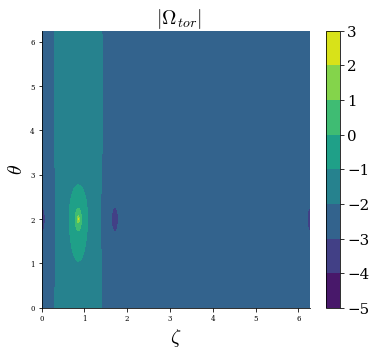

In [21]:
i = 11*1+3

omega_tor = omega_pair(
            sdata,
            dr_data["u_iso"][i], dr_data["v_iso"][i],
            dl_data["u_iso"][i], dl_data["v_iso"][i],
            N, d0
        )

plot_figure2( np.log10(np.abs(omega_tor)), sgrid,''r' $ | \Omega_{tor} |$')

In [22]:
test = rpz2xyz(dr_data['x'])# - dl_data['x']

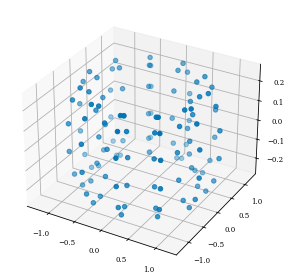

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test[:, 0], test[:, 1], test[:, 2])

In [24]:
dr_data['x'][0]

Array([ 1.23987324,  0.29059933, -0.07043314], dtype=float64)

In [25]:
j = 0

p1_ = dr_data['x'][0]

#phi2 = ( p2_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )
phi1 = ( p1_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )

#p2s = jnp.vstack((p2_[0], phi2, p2_[2])).T
#p2s = rpz2xyz(p2s)
p1s = jnp.vstack((p1_[0], phi1, p1_[2])).T
p1s = rpz2xyz(p1s)

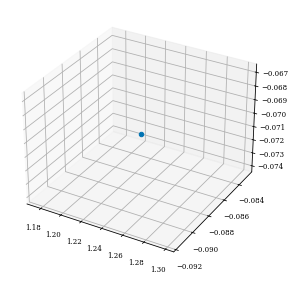

In [26]:
j = 0

p1_ = dr_data['x'][0]

#phi2 = ( p2_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )
phi1 = ( p1_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )

#p2s = jnp.vstack((p2_[0], phi2, p2_[2])).T
#p2s = rpz2xyz(p2s)
p1s = jnp.vstack((p1_[0], phi1, p1_[2])).T
p1s = rpz2xyz(p1s)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p1s[:, 0], p1s[:, 1], p1s[:, 2])

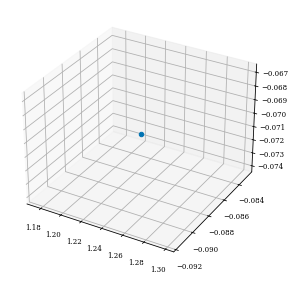

In [27]:
j = 1

p1_ = dr_data['x'][0]

#phi2 = ( p2_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )
phi1 = ( p1_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )

#p2s = jnp.vstack((p2_[0], phi2, p2_[2])).T
#p2s = rpz2xyz(p2s)
p1s = jnp.vstack((p1_[0], phi1, p1_[2])).T
p1s = rpz2xyz(p1s)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p1s[:, 0], p1s[:, 1], p1s[:, 2])

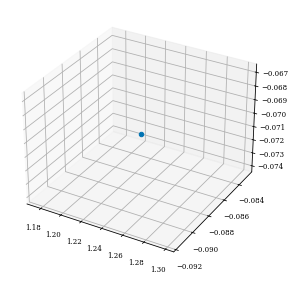

In [28]:
j = 3

p1_ = dr_data['x'][0]

#phi2 = ( p2_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )
phi1 = ( p1_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )

#p2s = jnp.vstack((p2_[0], phi2, p2_[2])).T
#p2s = rpz2xyz(p2s)
p1s = jnp.vstack((p1_[0], phi1, p1_[2])).T
p1s = rpz2xyz(p1s)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p1s[:, 0], p1s[:, 1], p1s[:, 2])

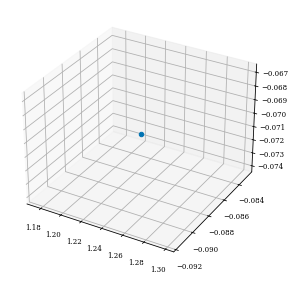

In [29]:
j = 0

p1_ = dr_data['x'][0]

#phi2 = ( p2_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )
phi1 = ( p1_[2] + j * 2 * jnp.pi / sgrid.NFP ) % ( 2 * jnp.pi )

#p2s = jnp.vstack((p2_[0], phi2, p2_[2])).T
#p2s = rpz2xyz(p2s)
p1ss = jnp.vstack((p1_[0], phi1, p1_[2])).T
p1ss = rpz2xyz(p1ss)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p1ss[:, 0], p1ss[:, 1], p1ss[:, 2])

In [30]:
p1s-p1ss

Array([[ 0.00000000e+00, -1.11022302e-15,  0.00000000e+00]], dtype=float64)

In [31]:
p1s

Array([[ 1.23679912, -0.08725598, -0.07043314]], dtype=float64)

In [32]:
p1ss

Array([[ 1.23679912, -0.08725598, -0.07043314]], dtype=float64)